
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P2_DQN_vs_DDQN.ipynb) [![Open in Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/DeepRLCourse/Homework-2-Questions/blob/main/HW2_P2_DQN_vs_DDQN.ipynb)

# **HW2: DQN vs DDQN**
---


> - Full Name: **Parsa Ghezelbash**
> - Student ID: **401110437**

## **Overview**

DQN, introduced in 2013, revolutionized deep reinforcement learning.  
In this notebook, you'll use PyTorch to train a Deep Q-Learning (DQN) agent on the [Cart-Pole](https://gymnasium.farama.org/environments/classic_control/cart_pole/) task from [Gymnasium](https://gymnasium.farama.org/). You'll also implement Double DQN (DDQN), an improved version with better stability, convergence, and test performance.

### In this notebook:
- Explore the Cart-Pole environment and observe an untrained agent.
- Set up a Gymnasium environment.
- Implement and train DQN and DDQN from scratch.
- Compare their performance to understand strengths and weaknesses.
- Render the trained agent’s behavior.

Before starting, import the necessary packages. Helper functions are provided for visualization and rendering.


## **Setup**  

First, install the required packages. If you're using Colab, everything should work smoothly. However, on a local system, you may encounter some dependency installation challenges.  


In [ ]:
!sudo apt-get update --quiet
!pip install imageio --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip install swig --quiet
!pip install gymnasium[box2d]

In [ ]:
import gymnasium as gym
import random
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from collections import namedtuple, deque

import base64
import json
import imageio
import IPython

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

## **Helper Functions**  
This section contains functions for visualizing your results.  


In [ ]:
# @title helper functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
plt.xkcd(scale=1, length=100, randomness=2)
matplotlib.rcParams['figure.figsize'] = (12, 6)


def plot_rewards(sum_of_rewards,i,show_result=False):
    plt.figure(1)
    rewards = torch.tensor(sum_of_rewards, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title(f'Training the Agent number {i}')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.plot(rewards.numpy())
    # Take 50 episode averages and plot them too
    length = len(rewards)
    init_len = min(49, length)
    init_means = np.cumsum(rewards[:init_len]) / (1 + np.arange(init_len))
    if length > 50:
        means = rewards.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((init_means, means))
    else:
        means = init_means
    plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

def plot_smooth(DDQN_mean_rewards,DDQN_min_rewards,DDQN_max_rewards,DQN_mean_rewards,DQN_min_rewards,DQN_max_rewards):
      plt.figure(figsize=(12,7))

      # Plot DDQN
      DDQN, = plt.plot(range(len(DDQN_mean_rewards)), DDQN_mean_rewards, color='blue', label='DDQN')
      plt.fill_between(range(len(DDQN_min_rewards)), DDQN_min_rewards, DDQN_max_rewards, color='blue', alpha=0.2)

      # Plot DQN
      DQN, = plt.plot(range(len(DQN_mean_rewards)), DQN_mean_rewards, color='red', label='DQN')
      plt.fill_between(range(len(DQN_min_rewards)), DQN_min_rewards, DQN_max_rewards, color='red', alpha=0.2)

      # Fix legend
      plt.legend(handles=[DDQN, DQN])
      plt.show()



def plot_values(values):
    plt.figure(figsize=(15, 9))

    # Iterate over each value set
    for i, value in enumerate(values):
        for n, Data in enumerate(value):
            plt.plot(range(len(Data)), Data, label=f"Values of selected trained Agent Number {i+1}, Evaluation {n+1}")

    plt.title('Test Episode Mean Q values')
    plt.xlabel("Episodes")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.show()



def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, agent, filename, num_episodes=1, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while True:
                state = torch.from_numpy(state).unsqueeze(0).to(device)
                action,_ = agent.act(state, greedy=True)
                state, reward, terminated, truncated, info = env.step(action)
                video.append_data(env.render())
                if terminated or truncated:
                    break
    return embed_mp4(filename)


def save_progress(sum_of_rewards, PATH):
    # Convert the list to a JSON string
    json_data = json.dumps(sum_of_rewards)
    # Write the JSON data to a file
    with open(PATH + str('.json'), "w") as file:
        file.write(json_data)


def load_progress(PATH):
    with open(PATH + str('.json'), "r") as file:
        json_data = file.read()
    # Load the JSON data back into a Python list
    return json.loads(json_data)

# **Explore the Environment (5 points)**

Let's explore the Gym Cart-Pole environment.  
First, we need to create the environment and set `rgb_array` as the render mode for visualization.  


In [ ]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
# TODO: Print the observation space and action space
print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Complete the following class to create an agent that selects actions randomly from the action space.  


In [ ]:
class RandomAgent():
    def __init__(self,env_name,mode='rgb_array'):
          self.env = gym.make(env_name, render_mode='rgb_array')

    def act(self,state = None,greedy = None):
        action = self.env.action_space.sample()
        return action,0

**Monitor the random Agent perfomance**

In [ ]:
random_agent = RandomAgent("CartPole-v1")
create_policy_eval_video(random_agent.env, random_agent, 'random_policy', num_episodes=5)

## **Main Components of DDQN and Its Variants**  

### **Deep Q Network (DQN)**  

DQN uses a neural network to estimate $Q(s,a)$ values. In theory, the network takes both state and action as input and outputs a single $Q(s,a)$ value. However, in practice, it takes only the state as input and outputs a vector of Q-values, where each value corresponds to an action in the action space.  

<img src="https://github.com/ParsaGhezelbash/DeepRL/blob/main/HW/HW%202/figs/network.jpg?raw=1" style="margin-left: 300px;">  

Now, let's define the Deep Q Network.  


In [ ]:
class QNetwork(nn.Module):
  def __init__(self, state_size, action_size):
      super(QNetwork, self).__init__()
      self.relu = nn.ReLU()
      self.fc1 = nn.Linear(state_size, 512)
      self.fc2 = nn.Linear(512, 125)
      self.fc3 = nn.Linear(125, action_size)


  def forward(self, state):
    x = self.relu(self.fc1(state))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    return x

## **Experience Replay Buffer**  

To train the network, we need data. We store **transitions**—tuples of (state, action, reward, next state, termination)—in a replay buffer for later sampling.  

- **state (s):** The current situation the agent is experiencing.  
- **action (a):** The action taken by the agent.  
- **next state (s'):** The new state after taking the action.  
- **reward (r):** The feedback received for the action.  
- **termination (done):** A boolean indicating if the episode has ended.  

These transitions are stored in the **Experience Replay Buffer**, allowing us to sample and train the Q-network efficiently.  not using replay buffer would make the learing highly unstable and inefficient.

A stack of transitions $(s, a, s', r, done)$ looks like this:  

<img src="https://github.com/ParsaGhezelbash/DeepRL/blob/main/HW/HW%202/figs/buffer.png?raw=1" style="margin-left: 300px;">  

**We shuffle the sampled data to break temporal correlations before training.**  

Now, let's define the Experience Replay Buffer class.  


## **Experience Replay Buffer**  

- `push`: Stores transitions from the environment.  
- `sample`: Shuffles and samples transitions.  
- `__len__` Returns the number of stored transitions.  
- `get_size`: Returns the buffer size  `__len__` as an output.  


In [ ]:
class ReplayMemory(object):
    def __init__(self, capacity, batch_size):
        self.memory = deque([],maxlen = capacity)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ("state", "action", "reward", "next_state", "done"))

    def push(self, state, action, reward, next_state, done):
            e = self.experience(state, action, reward, next_state, done)
            self.memory.append(e)

    def sample(self, batch_size=None):
            if batch_size is None:
                   batch_size = self.batch_size
            experiences = random.sample(self.memory, k=batch_size)
            states = np.vstack([e.state for e in experiences if e is not None])
            actions = np.vstack([e.action for e in experiences if e is not None])
            rewards = np.vstack([e.reward for e in experiences if e is not None])
            next_states = np.vstack([e.next_state for e in experiences if e is not None])
            dones = np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)
            return states, actions, rewards, next_states, dones

    def __len__(self):
              return len(self.memory)

    def get_size(self):
        return self.__len__()

## **DQN Agent**  

DQN, the first Deep RL algorithm, uses TD learning similar to Q-learning, aiming to minimize the distance:  

$r_i + \gamma \cdot max_{a'} Q_\theta'(s_i',a_i') - Q_\theta(s_i,a_i)$  

The more appropriate cost function is:  

$[r_i + \gamma \cdot max_{a'} Q_\theta(s_i',a_i') - Q_\theta(s_i,a_i)]^2$  $(1)$  

Instead of a tabular method, DQNs use deep networks to estimate Q-values.  

In this class, we implement the original DQN with an experience replay buffer. The training process is as follows:  

**Network Updating**  

1. Gather data. Once the buffer reaches a certain size, start training the Q-networks.  
2. Sample transitions and feed the States (instead of State-action pairs) to the Q-network to estimate $Q_\theta(s_i,a_i)$.  
3. Feed Next_States to the Q-network to estimate $Q_\theta(s_i',a_i')$.  
4. Use the average of equation $(1)$ to update the network via backpropagation.  


## **$\epsilon-\text{greedy policy}$**  

Exploration is crucial in RL algorithms. In DQN, exploration is achieved using the $\epsilon-\text{greedy policy}$.

$$
\pi(a \mid s) =
\begin{cases}
\arg\max\limits_{a} Q(s, a), & \text{with probability } 1 - \epsilon, \\
\text{random action}, & \text{with probability } \epsilon.
\end{cases}
$$


With probability $\epsilon$, a random action is chosen for exploration, and with probability $1 - \epsilon$, the best action is selected for exploitation.  

$\epsilon$ starts high and gradually decreases over time. The decay follows this formula:

$$\varepsilon = \varepsilon_{end} + \left(\varepsilon_{start} - \varepsilon_{end}\right)\exp\left(-\frac{\text{steps done}}{\text{decay rate}}\right)$$  

**The $\epsilon-\text{greedy policy}$ is used in both DQN and DDQN.**  

## **Original DQN Pseudocode**  

<img src="https://github.com/ParsaGhezelbash/DeepRL/blob/main/HW/HW%202/figs/DQN.png?raw=1" style="margin-left: 300px;">  

### Properties of the Algorithm:

- Uses a single network to estimate both $Q(s,a)$ and $Q(s',a')$, which can lead to instability—this is the problem DDQN aims to solve. **It's up to you to figure out why this is a problem.**  
- Utilizes the $\epsilon-\text{greedy}$ policy for exploration.

**Hint:**  
- A single network leads to unstable learning, hence the introduction of a target network in modified versions.  
- The $\epsilon-\text{greedy}$ policy can sometimes hinder the learning process, despite addressing the exploration problem.  

## **Implementing DQN class (20 points)**


In [ ]:
class DQNAgent(object):
    def __init__(self, q_network, memory, optimizer, criterion, params):
        self.policy_net = q_network(params['STATE_SIZE'], params['ACTION_SIZE']).to(device)
        self.target_net = q_network(params['STATE_SIZE'], params['ACTION_SIZE']).to(device).eval()
        self.target_net.load_state_dict(self.policy_net.state_dict())
        for param in self.target_net.parameters():
            param.requires_grad = False

        self.replay_buffer = memory(params['BUFFER_SIZE'], params['BATCH_SIZE'])
        # criterion, optimizer and params
        self.criterion = criterion()
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'], amsgrad=True)

        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        self.steps_done = 0
        self.Loss = []
        self.num_actions = params['ACTION_SIZE']
        self.num_states = params['STATE_SIZE']

    def step(self, state, action, reward, next_state, done):
        self.steps_done += 1
        self.replay_buffer.push(state, action, reward, next_state, done)

        if self.replay_buffer.get_size() > self.replay_buffer.batch_size:
            sample = self.replay_buffer.sample()
            states, actions, rewards, next_states, dones = sample
            self.learn(states, actions, rewards, next_states, dones)

    def act(self, state, greedy=False):
        self.eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])

        if greedy or random.random() > self.eps_threshold:
            with torch.no_grad():
                Q_values = self.policy_net(state)
                action = torch.argmax(Q_values).item()
                max_Q = torch.max(Q_values).item()
        else:
            action = random.randint(0, self.num_actions - 1)
            max_Q = 0

        return action, max_Q

    def learn(self, states, actions, rewards, next_states, dones):
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)
        state_Q = self.policy_net(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            next_state_Q = self.target_net(next_states)
            target_Q = (rewards + self.gamma * next_state_Q.max(1, keepdims=True)[0] * (1 - dones)).squeeze(1)

        loss = self.criterion(state_Q, target_Q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.Loss.append(loss.item())

        if self.steps_done % self.update_rate == 0:
            self.update_target_net()

    def update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')

# **Training the DQN Agents**

Now that you've implemented DQN and explored the Gym CartPole environment, it's time to train an actual agent.  

**First, we train the DQN agent.**  


## **Setting Up Essentials for DQN (5 points)**  

- **CartPole Environment Setup**  
- **Hyperparameter Initialization**  
- **Creating DQN Agents with Different Random Seeds**  
  - Why? Training multiple agents with different seeds helps assess DQN's consistency and robustness.  
  - We use **5 random seeds** for better evaluation.  
- **Defining Optimizer and Loss Function**  


In [ ]:
def create_dqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    return DQNAgent(QNetwork, ReplayMemory, optimizer, criterion, params)

params = {
    'UPDATE_RATE': 20,
    'BUFFER_SIZE': 1000,    # size of the replay buffer
    'BATCH_SIZE': 64,     # number of experiences sampled from memory
    'GAMMA': 0.99,          # discount factor
    'EPS_START': 0.99,      # starting value of epsilon
    'EPS_END': 0.1,        # final value of epsilon
    'EPS_DECAY': 40,      # rate of exponential decay of epsilon
    'LR': 0.001           # learning rate of the optimizer
}

# setting different seed values
seeds = [1, 10, 15, 43, 63]

env = gym.make('CartPole-v1')
env.reset()

n_actions = env.action_space.n
params['ACTION_SIZE'] = n_actions

n_observations = env.observation_space.shape[0]
params['STATE_SIZE'] = n_observations

optimizer = optim.Adam
criterion = nn.MSELoss

# initializing the agent list and sum of reward list
DQN_agents = []
dqn_sum_of_rewards = []
for seed in seeds:
    dqn_Agent = create_dqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params)
    DQN_agents.append(dqn_Agent)
    dqn_sum_of_rewards.append([])

## **Training Loop for the DQN Agent (10 points)**  

With the hyperparameters set, we can now train the agent.  

The code is designed for convenient retraining. simply re-run the segment to continue training if the agent hasn’t achieved satisfactory results.  


In [27]:
num_episodes = 400

for i, dqn_Agent in enumerate(DQN_agents):
    for e in range(1, num_episodes + 1):
        episode_reward = 0
        state, _ = env.reset()

        while True:
            state = torch.from_numpy(state).float().to(device)
            action, _ = dqn_Agent.act(state, greedy=False)
            next_state, reward, terminated, truncated, _ = env.step(action)

            dqn_Agent.step(state.cpu(), action, reward, next_state, terminated)
            state = next_state

            episode_reward += reward
            if terminated or truncated:
                break

        dqn_sum_of_rewards[i].append(episode_reward)
        # Save model every 50 episodes and plot the returns (change the rate if needed) , you can turn the plot off.
        if e % 50 == 0:
            plot_rewards(dqn_sum_of_rewards[i], i)
            path = f'DQN_{i}_Network' + (str(len(dqn_sum_of_rewards[i]))).zfill(4)
            dqn_Agent.save(path)
            save_progress(dqn_sum_of_rewards[i], path)

<Figure size 1200x600 with 0 Axes>

## **Why DDQN?**  

DQN and its variants use a replay buffer and Q-network, but DQN struggles with learning stability. **Can you identify why?**  
To address this, we introduce DDQN—a modified version with improved stability, capable of handling more complex environments.  

---

## **DDQN Agent**  

### **Deep Q-Networks in DDQN**  

DDQN uses two networks:  

- **Online Network**: Estimates $Q_\theta(s_i,a_i)$, representing the value of a state-action pair.  its parameters is denoted with $\theta$
- **Target Network**: Estimates $Q_{\theta'}(s_i',a_i')$, representing the value of the next state-action pair.  its parameters is denoted with $\theta'$

Both networks have identical architectures but serve different roles. The target network helps stabilize training by reducing overestimation bias.  

### **Network Updating**  

In DQN, a single network estimates both $Q(s_i,a_i)$ and $Q(s_i',a_i')$, leading to instability. DDQN introduces a key change:  

- The **online network** selects the best action:  
  $$ \arg\max_a Q_\theta(s'_i,a) $$
- The **target network** estimates its value:  
  $$ Q_{\theta'}(s_i, \arg\max_a Q_\theta(s'_i,a)) $$  

This modifies the loss function to:  

$$ [r_i + \gamma \cdot Q_{\theta'}(s_i, \arg\max_a Q_\theta(s'_i,a)) - Q_\theta(s_i,a_i)]^2 $$  

In this version DDQN, we also use $\text{soft replacemet}$ which is not a part of original DDQN, that another modification that is applied.
*   `soft_update` : The target network is updated at every step with a soft update controlled by the hyperparameter $\tau$, which was previously defined. The target is updated according to: $$\theta' \leftarrow \tau \theta + (1 - \tau) \theta'$$

## DDQN Psudocode

<img src="https://github.com/ParsaGhezelbash/DeepRL/blob/main/HW/HW%202/figs/DDQN.png?raw=1" style="margin-left: 300px;">  


Now, let's define the **DDQN class**.  


## **Impelementing DDQN Class (20 points)**

In [ ]:
class DDQNAgent(object):
    def __init__(self, q_network, memory, optimizer, criterion, params):
        self.policy_net = q_network(params['STATE_SIZE'], params['ACTION_SIZE']).to(device)
        self.target_net = q_network(params['STATE_SIZE'], params['ACTION_SIZE']).to(device).eval()
        self.target_net.load_state_dict(self.policy_net.state_dict())
        for param in self.target_net.parameters():
            param.requires_grad = False

        self.replay_buffer = memory(params['BUFFER_SIZE'], params['BATCH_SIZE'])
        # criterion, optimizer and params
        self.criterion = criterion()
        self.optimizer = optimizer(self.policy_net.parameters(), lr=params['LR'],amsgrad=True)
        self.tau = params['TAU']
        self.gamma = params['GAMMA']
        self.update_rate = params['UPDATE_RATE']
        self.eps = {'START': params['EPS_START'], 'END': params['EPS_END'], 'DECAY': params['EPS_DECAY']}
        self.steps_done = 0
        self.Loss = []
        self.num_actions = params['ACTION_SIZE']
        self.num_states = params['STATE_SIZE']

        self.soft_update(1)

    def step(self, state, action, reward, next_state, done):
        self.steps_done += 1
        self.replay_buffer.push(state, action, reward, next_state, done)

        if  self.replay_buffer.get_size() > self.replay_buffer.batch_size:
            sample = self.replay_buffer.sample()
            states, actions, rewards, next_states, dones = sample
            self.learn(states, actions, rewards, next_states, dones)

    def act(self, state, greedy=False, eps_threshold=None):
        self.eps_threshold = self.eps['END'] + (self.eps['START'] - self.eps['END']) * np.exp(- self.steps_done / self.eps['DECAY'])

        if greedy or random.random() > self.eps_threshold:
            with torch.no_grad():
                Q_values = self.policy_net(state)
                action = torch.argmax(Q_values).item()
                max_Q = torch.max(Q_values).item()
        else:
            action = random.randint(0, self.num_actions - 1)
            max_Q = 0

        return action, max_Q

    def learn(self, states, actions, rewards, next_states, dones):
        states = torch.from_numpy(states).float().to(device)
        actions = torch.from_numpy(actions).long().to(device)
        rewards = torch.from_numpy(rewards).float().to(device)
        next_states = torch.from_numpy(next_states).float().to(device)
        dones = torch.from_numpy(dones).float().to(device)

        state_Q = self.policy_net(states).gather(1, actions).squeeze(1)

        with torch.no_grad():
            best_next_action = self.policy_net(next_states).argmax(dim=1, keepdims=True)

            Q_next = self.target_net(next_states).gather(1, best_next_action).squeeze(1)

            target_Q = (rewards + self.gamma * Q_next * (1 - dones)).squeeze(1)

        loss = self.criterion(state_Q, target_Q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.Loss.append(loss.item())

        if self.steps_done % self.update_rate == 0:
            self.soft_update(self.tau)

    def soft_update(self, tau):
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    # use these functions to save and load the model
    def save(self, PATH):
        torch.save(self.policy_net, PATH + '_policy.pt')
        torch.save(self.target_net, PATH + '_target.pt')

    def load(self, PATH):
        self.policy_net = torch.load(PATH + '_policy.pt')
        self.target_net = torch.load(PATH + '_target.pt')

## **Setting Up Essentials for DDQN (5 points)**  

- **CartPole Environment Setup**  
- **Hyperparameter Initialization**  
- **Creating DDQN Agents with Different Random Seeds**  
  - Why? Training multiple agents with different seeds helps assess DDQN's consistency and robustness.  
  - We use **5 random seeds** for better evaluation.  
- **Defining Optimizer and Loss Function**  


In [ ]:
def create_ddqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    return DDQNAgent(QNetwork, ReplayMemory, optimizer, criterion, params)

params = {
    'UPDATE_RATE': 20,    # how often to update the network
    'BUFFER_SIZE': 1000,    # size of the replay buffer
    'BATCH_SIZE': 64,     # number of experiences sampled from memory
    'GAMMA': 0.99,          # discount factor
    'EPS_START': 0.99,      # starting value of epsilon
    'EPS_END': 0.1,        # final value of epsilon
    'EPS_DECAY': 40,      # rate of exponential decay of epsilon 35000
    'TAU': 0.8,            # update rate of the target network 0.008
    'LR': 0.001           # learning rate of the optimizer
}

# setting different seed values
seeds = [1, 10, 15, 43, 63]

env = gym.make('CartPole-v1')
env.reset()

n_actions = env.action_space.n
params['ACTION_SIZE'] = n_actions

n_observations = env.observation_space.shape[0]
params['STATE_SIZE'] = n_observations

optimizer = optim.Adam
criterion = nn.MSELoss

# initializing the agent list and sum of reward list
agents = []
sum_of_rewards = []
for seed in seeds:
    Agent = create_ddqn_agent(seed, QNetwork, ReplayMemory, optimizer, criterion, params)
    agents.append(Agent)
    sum_of_rewards.append([])

## **Training Loop for DDQN Agent (10 points)**  

With the hyperparameters set, we can now train the agent. The following code allows for easy re-training—if the agent's performance isn't satisfactory, simply re-run the segment to continue training for more episodes.  


In [ ]:
num_episodes = 400

for i, DDQN_agent in enumerate(agents):
    for e in range(1, num_episodes + 1):
        episode_reward = 0
        state, _ = env.reset()

        while True:
            state = torch.from_numpy(state).float().to(device)
            action, _ = DDQN_agent.act(state, greedy=False)
            next_state, reward, terminated, truncated, _ = env.step(action)

            DDQN_agent.step(state.cpu(), action, reward, next_state, terminated)
            state = next_state

            episode_reward += reward
            if terminated or truncated:
                break

        sum_of_rewards[i].append(episode_reward)
        # Save model every 50 episodes and plot the returns (change the rate if needed) , you can turn the plot off.
        if e % 50 == 0:
              plot_rewards(sum_of_rewards[i],i)
              path = f'DDQN_{i}_Network' + (str(len(sum_of_rewards[i]))).zfill(4)
              DDQN_agent.save(path)
              save_progress(sum_of_rewards[i], path)

## **Computing the Moving Average of Results (5 points)**  

We compute a moving average to smooth the results for both DDQN and DQN across all seeds. This includes the average of the minimum, maximum, and actual returns across all seeds and episodes.  


In [ ]:
def moving_average(data, window_size=25):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Compute moving averages for DDQN
DDQN_mean_rewards = moving_average(np.array(sum_of_rewards).mean(axis=0))
DDQN_min_rewards = moving_average(np.array(sum_of_rewards).min(axis=0))
DDQN_max_rewards = moving_average(np.array(sum_of_rewards).max(axis=0))

# Compute moving averages for DQN
DQN_mean_rewards = moving_average(np.array(dqn_sum_of_rewards).mean(axis=0))
DQN_min_rewards = moving_average(np.array(dqn_sum_of_rewards).min(axis=0))
DQN_max_rewards = moving_average(np.array(dqn_sum_of_rewards).max(axis=0))

## **Visualizing the Outputs (5 points)**  

Plotting the smoothed results with:  
- Lower bound as the average of minimum returns  
- Upper bound as the average of maximum returns  
- Actual moving average of the returns  

for smoother plots, you can increase the **window_size** in `moving_average` function.


In [ ]:
plot_smooth(DDQN_mean_rewards,DDQN_min_rewards,DDQN_max_rewards,DQN_mean_rewards,DQN_min_rewards,DQN_max_rewards)

## **Takeaway Questions**
- Which algorithm, DQN or DDQN, exhibits more stable learning?
    - Consider mean returns and the tightness of the upper and lower bounds in the training plot.
- Which algorithm struggles less during learning?

## **Model Evaluation (10 points)**  

To evaluate the model, we measure the **average reward** and its **standard deviation** using the following function.  


In [28]:
def evaluate_policy(env, agent, num_episodes=3):
    total_reward = 0
    Episode_values = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        values = []
        mean_value = []

        while True:
            state = torch.from_numpy(state).float().to(device)
            action, Q = agent.act(state, greedy=True)
            next_state, reward, done, truncated, _ = env.step(action)
            state = next_state
            total_reward += reward

            # appending Q values for later use
            ###################################################
            values.append(Q)
            mean_value.append(np.array(values).mean())
            ###################################################

            if done or truncated:
                break

        Episode_values.append(mean_value)

    mean = total_reward / num_episodes
    std = np.std(total_reward)

    return mean, std, Episode_values

**Run both trained policies for 3 episodes, observe the mean and std of returns, and plot the mean Q-values per episode. If the agent passes the evaluation bar, plot their mean values.**

## **Plot DDQN values**

evaluating the 0th agent mean_reward = 9.666666666666666 +/- 0.0

evaluating the 1th agent mean_reward = 9.0 +/- 0.0

evaluating the 2th agent mean_reward = 64.33333333333333 +/- 0.0

evaluating the 3th agent mean_reward = 500.0 +/- 0.0

evaluating the 4th agent mean_reward = 312.0 +/- 0.0



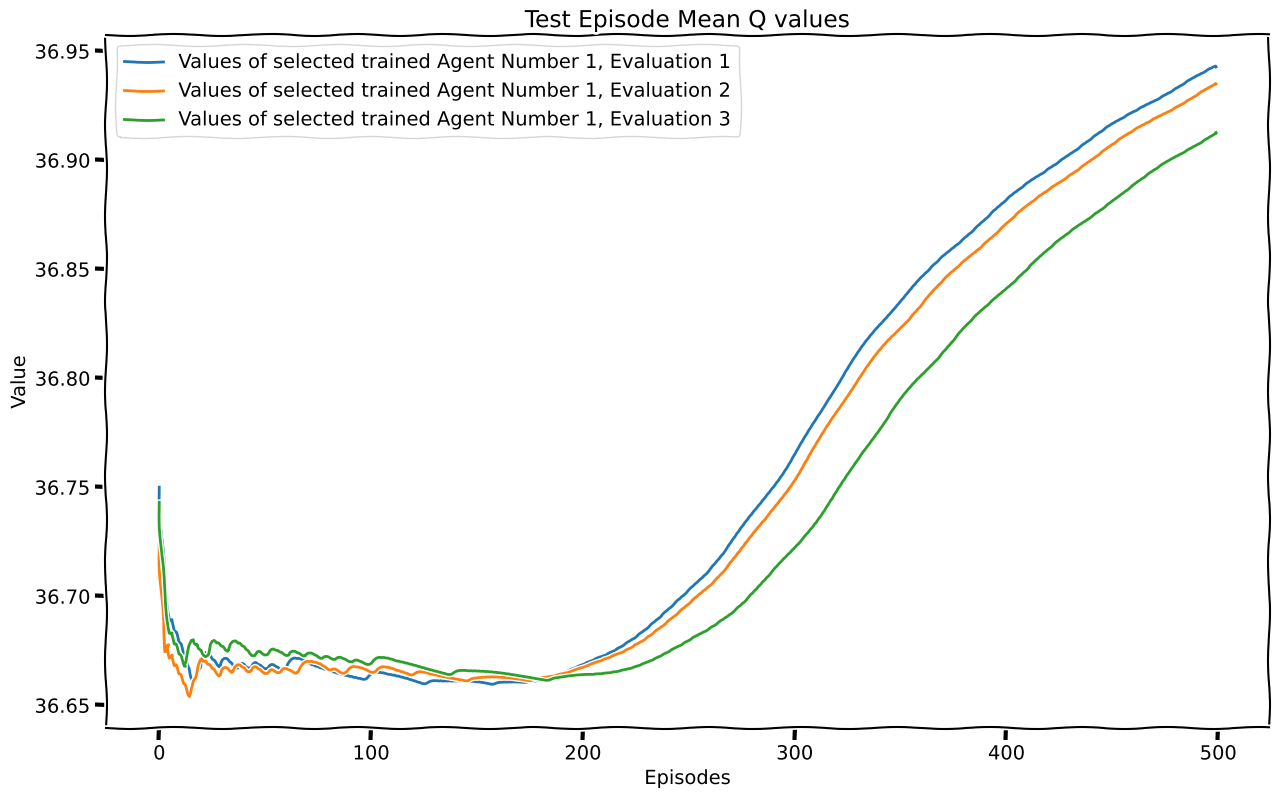

In [29]:
DDQN_values, DDQN_rewards = [], []

for i, DDQN_agent in enumerate(agents):
    mean_reward, std_reward, mean_values = evaluate_policy(env, DDQN_agent)
    print(f"evaluating the {i}th agent mean_reward = {mean_reward} +/- {std_reward}\n")
    if mean_reward >= 450:
        DDQN_values.append(mean_values)
    DDQN_rewards.append(mean_reward)

if len(DDQN_values) != 0:
    plot_values(DDQN_values)
else:
    print('[Info] ... the Agent Did not pass the minimum requirement Please train it more.')

## **Plot DQN values**

evaluating the 0th agent mean_reward = 241.0 +/- 0.0

evaluating the 1th agent mean_reward = 9.666666666666666 +/- 0.0

evaluating the 2th agent mean_reward = 500.0 +/- 0.0

evaluating the 3th agent mean_reward = 500.0 +/- 0.0

evaluating the 4th agent mean_reward = 500.0 +/- 0.0



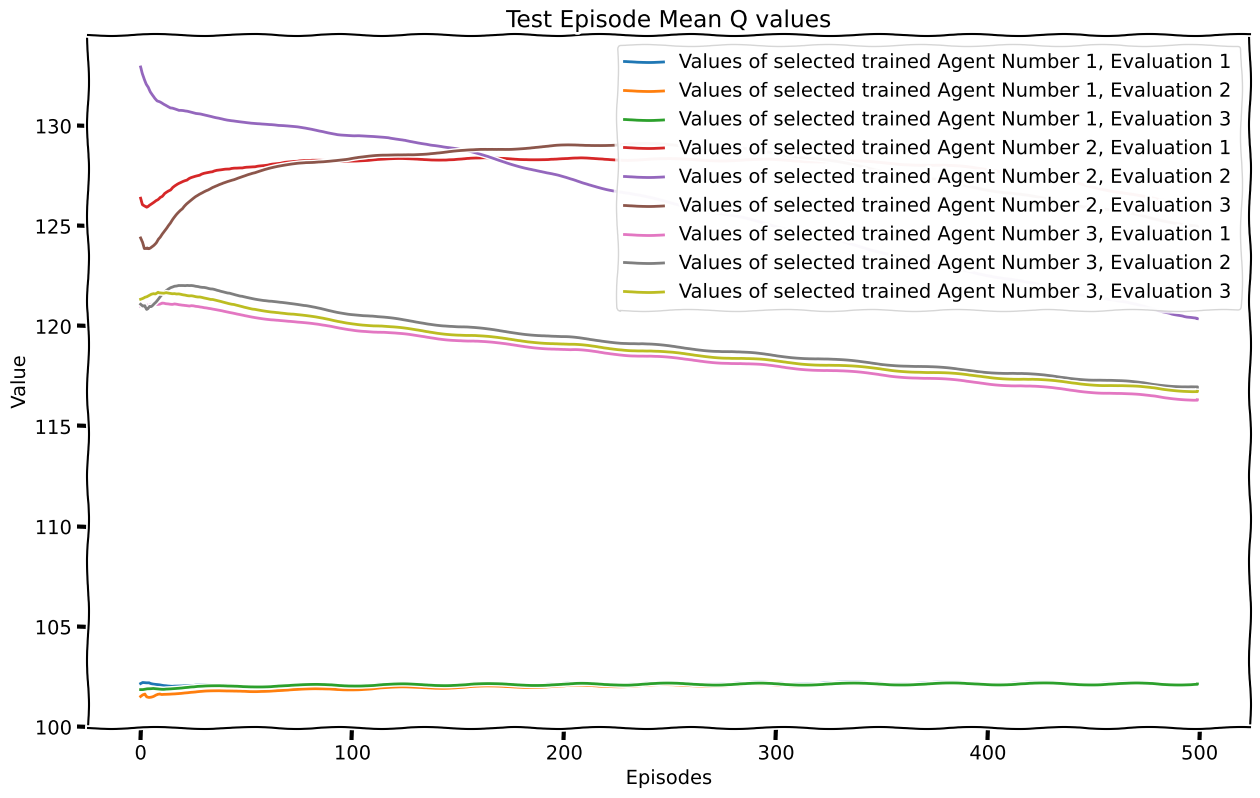

In [30]:
DQN_values, DQN_rewards = [], []

for i, DQN_agent in enumerate(DQN_agents):
    mean_reward, std_reward,mean_values = evaluate_policy(env, DQN_agent)
    print(f"evaluating the {i}th agent mean_reward = {mean_reward} +/- {std_reward}\n")
    if mean_reward >= 450:
        DQN_values.append(mean_values)
    DQN_rewards.append(mean_reward)

if len(DQN_values) != 0:
    plot_values(DQN_values)
else:
    print('[Info] ... the Agent Did not pass the minimum requirement Please train it more.')

## **Watch the best Agent's performance (5 points)**
**Select one of the best agents from the evaluation step and render its performance.**

**Rendering DDQN Agent**

In [31]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
print('[info] ... rendering the DDQN Agent performance')
best_agent = agents[np.argmax(DDQN_rewards)]
create_policy_eval_video(env, best_agent, 'DQN best agent', num_episodes=5)

[info] ... rendering the DDQN Agent performance


**Rendering DQN Agent**

In [32]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
print('[info] ... rendering the DQN Agent performance')
# TODO: from the previous evaluation Select one of the best Agent to render the performance
best_agent = DQN_agents[np.argmax(DQN_rewards)]
create_policy_eval_video(env, best_agent, 'DQN best agent', num_episodes=5)

[info] ... rendering the DQN Agent performance


## **Takeaway Questions**
- Which agent is trained better considering the evaluation and rendering the performance?
- One of the DDQN's goal is to prevent Q values over estimation. Did you observe this phenomenon after ploting the Mean Q values and comparing them to DQN values?